<a href="https://colab.research.google.com/github/gokulakrishnanbalaji/semeval-sentence-relatedness/blob/main/Telugu_lang_sem_eval_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from scipy.stats import spearmanr
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
#Loading dataset into a pandas dataframe
df = pd.read_csv('/content/telugu.csv')

In [ ]:
#exploring few rows of dataframe
df.head()

,PairID,Text,Score
0,TEL-train-00001,"""జమ్మూకాశ్మీర్లో మంచుకొండచరియలు విరిగిపడి గురు...",0.88
1,TEL-train-00002,"""కూతురుపైనే కన్నతండ్రి అత్యాచారానికి పాల్పడిన ...",0.87
2,TEL-train-00003,"""గంగా నదిని కాపాడేందుకు ప్రత్యేక చట్టం తీసుకుర...",0.87
3,TEL-train-00004,"""కరోనా వైరస్పై అమెరికా ప్రభుత్వానికి వ్యతిరేకం...",0.84
4,TEL-train-00005,"""కరోనా వైరస్ ( కొవిడ్ - 19 ) మనుషులపైనే కాదు జ...",0.84


In [ ]:
# we are having pair id, text, score.
# we need to convert them into text1, text2, score format.

df.drop('PairID', axis=1, inplace=True) #Removing pair ID
df[['text1', 'text2']] = df['Text'].str.split('\n', 1, expand=True) # Splitting into text1 and text2
df.drop('Text', axis=1, inplace=True) #Removing Text column, as it is redundant

<ipython-input-5-4a36f28d983e>:5: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['text1', 'text2']] = df['Text'].str.split('\n', 1, expand=True) # Splitting into text1 and text2


In [ ]:
df.head()
# we have our data in score, text1 and text2 format

,Score,text1,text2
0,0.88,"""జమ్మూకాశ్మీర్లో మంచుకొండచరియలు విరిగిపడి గురు...","""జమ్మూకాశ్మీర్లో మంచుకొండచరియలు విరిగిపడిన ఘటన..."
1,0.87,"""కూతురుపైనే కన్నతండ్రి అత్యాచారానికి పాల్పడిన ...","""కన్నతండ్రి కూతురుపై అత్యాచారం చేసిన దారుణ ఘటన..."
2,0.87,"""గంగా నదిని కాపాడేందుకు ప్రత్యేక చట్టం తీసుకుర...","""గంగానదిని రక్షించేందుకు ప్రత్యేక చట్టం తేవాలన..."
3,0.84,"""కరోనా వైరస్పై అమెరికా ప్రభుత్వానికి వ్యతిరేకం...","""అమెరికా ప్రభుత్వానికి కరోనా వైరస్పై జరుగుతున్..."
4,0.84,"""కరోనా వైరస్ ( కొవిడ్ - 19 ) మనుషులపైనే కాదు జ...","""కరోనావైరస్ (కోవిడ్-19) మానవులకు మరియు జంతువుల..."


In [ ]:
#check the size of dataset
df.shape

(1170, 3)

In [ ]:
# Check for Missing values
df.isna().sum()

#No missing values

Score    0
text1    0
text2    0
dtype: int64

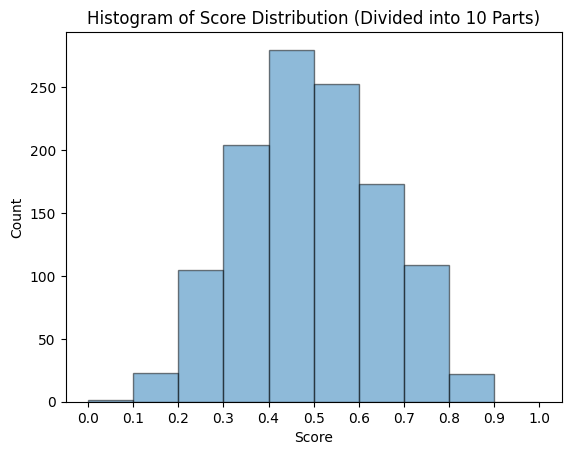

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of bins
num_bins = 10

# Calculate the bin edges
bin_edges = np.linspace(0, 1, num_bins + 1)

# Use the histogram function to compute the bin counts
hist, _ = np.histogram(df['Score'], bins=bin_edges)

# Plot the histogram
plt.hist(df['Score'], bins=bin_edges, edgecolor='k', alpha=0.5)
plt.title("Histogram of Score Distribution (Divided into 10 Parts)")
plt.xlabel("Score")
plt.ylabel("Count")

# Customize the x-axis labels to show the bin edges
plt.xticks(bin_edges)

plt.show()


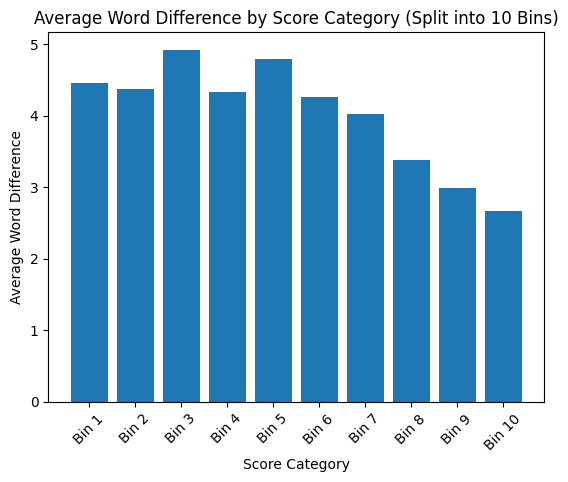

In [ ]:
import numpy as np

# Define the number of bins
num_bins = 10

# Calculate the bin edges
score_percentiles = np.percentile(df['Score'], np.linspace(0, 100, num_bins + 1))

# Use the digitize function to assign each row to a bin
df['ScoreCategory'] = np.digitize(df['Score'], score_percentiles, right=True)

# Function to calculate the word difference between two sentences
def calculate_word_difference(string1, string2):
    words1 = string1.split()
    words2 = string2.split()
    return abs(len(words1) - len(words2))

# Calculate the word difference between text1 and text2 for each row in the dataframe
df['word_difference'] = df.apply(lambda row: calculate_word_difference(row['text1'], row['text2']), axis=1)

# Calculate the average word difference for each score category
avg_word_difference = []

for category in range(1, num_bins + 1):
    avg_word_diff = df[df['ScoreCategory'] == category]['word_difference'].mean()
    avg_word_difference.append(avg_word_diff)

# Create labels for the score categories
category_labels = [f'Bin {i}' for i in range(1, num_bins + 1)]

# Plot a bar chart of the average word difference for each category
plt.bar(category_labels, avg_word_difference)
plt.title("Average Word Difference by Score Category (Split into 10 Bins)")
plt.xlabel("Score Category")
plt.ylabel("Average Word Difference")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# we will use AI4Bharat model to predict the sentence similarity and compare with actual score
!pip install sentencepiece
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
model_name = "sentence-transformers/LaBSE"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/LaBSE and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.7, random_state=42)
dev_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
def tokenize_text(df):
    return tokenizer(list(df['text1']), list(df['text2']), padding='max_length', truncation=True, return_tensors='pt')

train_dataset = tokenize_text(train_df)
dev_dataset = tokenize_text(dev_df)
test_dataset = tokenize_text(test_df)

# Convert your Score column to a tensor
train_labels = torch.tensor(train_df['Score'].to_numpy(), dtype=torch.float32)
dev_labels = torch.tensor(dev_df['Score'].to_numpy(), dtype=torch.float32)
test_labels = torch.tensor(test_df['Score'].to_numpy(), dtype=torch.float32)


In [ ]:
num_epochs = 3
batch_size = 8
learning_rate = 1e-5

# Create DataLoader for training
train_data = TensorDataset(train_dataset['input_ids'], train_dataset['attention_mask'], train_labels)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:

# Training loop with evaluation after each epoch
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Avg Loss: {avg_loss:.4f}")

    # Evaluate the model on the dev dataset
    model.eval()
    with torch.no_grad():
        outputs = model(**dev_dataset)
        predicted_scores = outputs.logits.squeeze().detach().cpu().numpy()


        # Calculate the Spearman correlation
        spearman_corr, _ = spearmanr(predicted_scores, dev_labels)
        print(f"Epoch {epoch + 1} - Spearman Correlation on Dev Data: {spearman_corr:.4f}")

Epoch 1, Avg Loss: 1.8748
[-0.16396593 -0.14000577] tensor([0.8800, 0.8700])
Epoch 1 - Spearman Correlation on Dev Data: -1.0000
Epoch 2, Avg Loss: 0.9041
[-0.03213272  0.02446249] tensor([0.8800, 0.8700])
Epoch 2 - Spearman Correlation on Dev Data: -1.0000
Epoch 3, Avg Loss: 0.5079
[0.09417292 0.18233792] tensor([0.8800, 0.8700])
Epoch 3 - Spearman Correlation on Dev Data: -1.0000


In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(**test_dataset)
    predicted_scores_test = outputs.logits.squeeze().detach().cpu().numpy()

    # Calculate the Spearman correlation for the test dataset
    spearman_corr_test, _ = spearmanr(predicted_scores_test, test_labels)
    print(f"Spearman Correlation on Test Data: {spearman_corr_test:.4f}")

[ 0.10920937 -0.06659766 -0.21153136] tensor([0.8700, 0.8400, 0.8400])
Spearman Correlation on Test Data: 0.8660
